# Combined big figures

In [1]:
# Import packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import seaborn as sns
import sparseRRR
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.tri as tri
import importlib

import bottleneck_networks_tf2

import time
import pickle
import warnings

dtype = tf.float32

## Loading data

In [6]:
scala = pickle.load(open('data/scala_2020/scala2020.pickle', 'rb'))
gouwens = pickle.load(open('data/gouwens_2020/gouwens2020.pickle', 'rb'))
stoeckius = pickle.load(open('data/stoeckius_2017/stoeckius_2017.pickle', 'rb'))
scala_icg = pickle.load(open('data/scala_2020/scala2020_with_ion_channel_genes.pickle', 'rb'))

## Keras initialisations

In [7]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [9]:
tf.compat.v1.disable_eager_execution()

In [10]:
def r2_score(y_truth, y_pred):
    residual = tf.add(y_truth, -y_pred, name='residual')
    return 1-tf.reduce_sum(input_tensor=tf.square(residual)) / tf.reduce_sum(input_tensor=tf.square(y_truth))

In [11]:
class ElasticNet(tf.keras.regularizers.Regularizer): 
    def __init__(self, l1=1e-8, l2=1.0): 
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x): 
        return self.l2*tf.math.reduce_sum(input_tensor=tf.math.square(x)) + \
                             self.l1*tf.reduce_sum(input_tensor=tf.norm(tensor=x, ord = 2, axis = 1))

    def get_config(self): 
        return {'l1': float(self.l1), 'l2': float(self.l2)}

## Combined Figures

First some functions

In [12]:
from openTSNE import TSNE

In [13]:
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

In [130]:
def latent_space_ephys(model, latent, X, Y, Y_column_index, features, alpha = 1, triangle_max_len=50,
                       fontsize=13, axis = None):
    '''
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    latent: latent space projections
    X: 2D numpy array, normalized transcriptomic data
    Y: 2D numpy array, normalized ephys data
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    alpha: transparancy for contours (default = 0.5)
    triangle_max_len: # triangles with too long edges (poorly constrained by data) (default=50)
    fontsize: fontsize of title (default: 13)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure objects; latent space with gene activation contours
    '''
    # Create mappings from the model to get latent activations from genes and ephys predictions from genes and
    # latent activations
    ephys_prediction = model.predict(X)

    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))      
    
    # produces triangles from latent coordinates
    triang = tri.Triangulation(latent[:,0], latent[:,1])
    
    # extract coordinates of each triangle
    x1=latent[:,0][triang.triangles][:,0]
    x2=latent[:,0][triang.triangles][:,1]
    x3=latent[:,0][triang.triangles][:,2]
    y1=latent[:,1][triang.triangles][:,0]
    y2=latent[:,1][triang.triangles][:,1]
    y3=latent[:,1][triang.triangles][:,2]
    
    # calculate the area of each triangle
    #A=1/2 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    
    # calculate edges
    edges=np.concatenate((np.sqrt((x2-x1)**2+(y2-y1)**2)[:,np.newaxis],
                np.sqrt((x3-x1)**2+(y3-y1)**2)[:,np.newaxis],
                np.sqrt((x2-x3)**2+(y2-y3)**2)[:,np.newaxis]), axis=1)
    
    # triangles with an edge longer than the 50th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(np.max(edges, axis=1)>np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-triangle_max_len])
    
    ax.tricontourf(triang, ephys_prediction[:, Y_column_index], cmap='inferno',
                   levels=np.linspace(-2,2,40), extend='both')
    ax.set_xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
    ax.set_ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=fontsize, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [187]:
def latent_space_genes(model, latent, Z, X, X_column_index, geneNames, alpha = 1, triangle_max_len=50,
                       fontsize=13, axis = None):
    '''
    Parameters
    ----------
    model: keras decoder network (from latent space to selected genes)
    latent: latent space
    Z: projections (could be same as latent)
    X: 2D numpy array, normalized transcriptomic data (should be a selected genes i.e. reduced size matrix)
    X_column_index: column index in X, correspoding to certain gene
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    alpha: transparancy for contours (default = 0.5)
    triangle_max_len: # triangles with too long edges (poorly constrained by data) (default=50)
    fontsize: fontsize of title (default: 13)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure objects; latent space with gene activation contours
    '''
    gene_prediction=model.predict(latent)
    
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))    
    
    # produces triangles from latent coordinates
    triang = tri.Triangulation(Z[:,0], Z[:,1])
    
    # extract coordinates of each triangle
    x1=Z[:,0][triang.triangles][:,0]
    x2=Z[:,0][triang.triangles][:,1]
    x3=Z[:,0][triang.triangles][:,2]
    y1=Z[:,1][triang.triangles][:,0]
    y2=Z[:,1][triang.triangles][:,1]
    y3=Z[:,1][triang.triangles][:,2]
    
    # calculate the area of each triangle
    # A=1/2 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    
    
    # calculate edges
    edges=np.concatenate((np.sqrt((x2-x1)**2+(y2-y1)**2)[:,np.newaxis],
                np.sqrt((x3-x1)**2+(y3-y1)**2)[:,np.newaxis],
                np.sqrt((x2-x3)**2+(y2-y3)**2)[:,np.newaxis]), axis=1)
    
    # triangles with an edge longer than the 50th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(np.max(edges, axis=1)>np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-triangle_max_len])
    ax.tricontourf(triang, gene_prediction[:, X_column_index], cmap='inferno',
                   levels=np.linspace(-2,2,40), extend='both')
    ax.set_xlim([np.min(Z[:, 0]), np.max(Z[:, 0])])
    ax.set_ylim([np.min(Z[:, 1]), np.max(Z[:, 1])])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[X_column_index], fontsize=fontsize, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [97]:
def latent_space_ephys_sRRR(latent, Z, vy, Y_column_index, features, alpha = 1, triangle_max_len=50, fontsize=13,
                            axis = None):
    '''
    Parameters
    ----------
    latent: latent space
    Z: projections (could be same as latent)
    vy: matrix to (linearly) project from latent space to ephys space
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    alpha: transparancy for contours (default = 0.5)
    triangle_max_len: # triangles with too long edges (poorly constrained by data) (default=50)
    fontsize: fontsize of title (default: 13)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure object, latent space with ephys activation contours
    '''
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    # produces triangles from latent coordinates
    triang = tri.Triangulation(Z[:,0], Z[:,1])
    
    # extract coordinates of each triangle
    x1=Z[:,0][triang.triangles][:,0]
    x2=Z[:,0][triang.triangles][:,1]
    x3=Z[:,0][triang.triangles][:,2]
    y1=Z[:,1][triang.triangles][:,0]
    y2=Z[:,1][triang.triangles][:,1]
    y3=Z[:,1][triang.triangles][:,2]
    
    # calculate the area of each triangle
    # A=1/2 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    
    
    # calculate edges
    edges=np.concatenate((np.sqrt((x2-x1)**2+(y2-y1)**2)[:,np.newaxis],
                np.sqrt((x3-x1)**2+(y3-y1)**2)[:,np.newaxis],
                np.sqrt((x2-x3)**2+(y2-y3)**2)[:,np.newaxis]), axis=1)
    
    # triangles with an edge longer than the 20th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(np.max(edges, axis=1)>np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-triangle_max_len])
    ax.tricontourf(triang, (latent@vy.T)[:, Y_column_index], cmap='inferno',
                   levels=np.linspace(-1,1,40), extend='both')
    
    ax.set_xlim([np.min((Z)[:, 0]), np.max((Z)[:, 0])])
    ax.set_ylim([np.min((Z)[:, 1]), np.max((Z)[:, 1])])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=fontsize, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [98]:
def latent_space_genes_sRRR(latent, Z, vx, index, geneNames, alpha = 0.5, triangle_max_len=50, fontsize=13, axis = None):
    ''' 
    Parameters
    ----------
    latent: latent space
    Z: projections (could be same as latent)
    index: index in the 25 genes selected for the gene that you'd like to show
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    alpha: transparancy for contours (default = 0.5)
    triangle_max_len: # triangles with too long edges (poorly constrained by data) (default=50)
    fontsize: fontsize of title (default: 13)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    axis: figure objects; latent space with gene activation contours
    '''
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    # produces triangles from latent coordinates
    triang = tri.Triangulation(Z[:,0], Z[:,1])
    
    # extract coordinates of eacht triangle
    x1=Z[:,0][triang.triangles][:,0]
    x2=Z[:,0][triang.triangles][:,1]
    x3=Z[:,0][triang.triangles][:,2]
    y1=Z[:,1][triang.triangles][:,0]
    y2=Z[:,1][triang.triangles][:,1]
    y3=Z[:,1][triang.triangles][:,2]
    
    # calculate the area of each triangle
    # A=1/2 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    
    
    # calculate edges
    edges=np.concatenate((np.sqrt((x2-x1)**2+(y2-y1)**2)[:,np.newaxis],
                np.sqrt((x3-x1)**2+(y3-y1)**2)[:,np.newaxis],
                np.sqrt((x2-x3)**2+(y2-y3)**2)[:,np.newaxis]), axis=1)
    
    # triangles with an edge longer than the 20th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(np.max(edges, axis=1)>np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-triangle_max_len])
    ax.tricontourf(triang, latent@np.linalg.pinv(vx)[:, np.sum(vx, axis = 1)!=0][:, index], cmap='inferno',
                   levels=np.linspace(-1,1,40), extend='both')
    ax.set_xlim([np.min(Z[:, 0]), np.max(Z[:, 0])])
    ax.set_ylim([np.min(Z[:, 1]), np.max(Z[:, 1])])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[np.sum(vx, axis = 1)!=0][index], fontsize=fontsize, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [175]:
def create_axes(fig):
    # return axes to construct a less big figure
    
    if fig is None:
        fig = plt.figure(figsize=(9, 6))
    else: fig = fig
    
    width = 0.1 # width of every small heatmap plot
    height = 0.135 # height of every small heatmap plot
    
    b_ax_latent=plt.axes([.33,0.5,0.31,0.45])
    b_ax_genes_1=plt.axes([0,0.82,width,height])
    b_ax_genes_2=plt.axes([0.11,0.82,width,height])
    b_ax_genes_3=plt.axes([0.22,0.82,width,height])
    
    b_ax_genes_4=plt.axes([0,0.66,width,height])
    b_ax_genes_5=plt.axes([0.11,0.66,width,height])
    b_ax_genes_6=plt.axes([0.22,0.66,width,height])
    
    b_ax_genes_7=plt.axes([0,0.5,width,height])
    b_ax_genes_8=plt.axes([0.11,0.5,width,height])
    b_ax_genes_9=plt.axes([0.22,0.5,width,height])
    
    b_ax_ephys_1=plt.axes([0.66,0.82, width,height])
    b_ax_ephys_2=plt.axes([0.77,0.82, width,height])
    b_ax_ephys_3=plt.axes([0.88,0.82, width,height])
    
    b_ax_ephys_4=plt.axes([0.66,0.66, width,height])
    b_ax_ephys_5=plt.axes([0.77,0.66, width,height])
    b_ax_ephys_6=plt.axes([0.88,0.66, width,height])
    
    b_ax_ephys_7=plt.axes([0.66,0.5, width,height])
    b_ax_ephys_8=plt.axes([0.77,0.5, width,height])
    b_ax_ephys_9=plt.axes([0.88,0.5, width,height])
    
    ax_latent=plt.axes([.33,0,0.31,0.45])    
    ax_genes_1=plt.axes([0,0.32,width,height])
    ax_genes_2=plt.axes([0.11,0.32,width,height])
    ax_genes_3=plt.axes([0.22,0.32,width,height])
    
    ax_genes_4=plt.axes([0,0.16,width,height])
    ax_genes_5=plt.axes([0.11,0.16,width,height])
    ax_genes_6=plt.axes([0.22,0.16,width,height])
    
    ax_genes_7=plt.axes([0,0,width,height])
    ax_genes_8=plt.axes([0.11,0,width,height])
    ax_genes_9=plt.axes([0.22,0,width,height])
    
    ax_ephys_1=plt.axes([0.66,0.32, width,height])
    ax_ephys_2=plt.axes([0.77,0.32, width,height])
    ax_ephys_3=plt.axes([0.88,0.32, width,height])
    
    ax_ephys_4=plt.axes([0.66,0.16, width,height])
    ax_ephys_5=plt.axes([0.77,0.16, width,height])
    ax_ephys_6=plt.axes([0.88,0.16, width,height])
    
    ax_ephys_7=plt.axes([0.66, 0, width,height])
    ax_ephys_8=plt.axes([0.77, 0, width,height])
    ax_ephys_9=plt.axes([0.88, 0, width,height])
    
    
    return [b_ax_latent, b_ax_genes_1, b_ax_genes_2, b_ax_genes_3, b_ax_genes_4, b_ax_genes_5, b_ax_genes_6, \
            b_ax_genes_7, b_ax_genes_8, b_ax_genes_9, b_ax_ephys_1, b_ax_ephys_2, b_ax_ephys_3, b_ax_ephys_4, \
            b_ax_ephys_5, b_ax_ephys_6, b_ax_ephys_7, b_ax_ephys_8, b_ax_ephys_9, \
            ax_latent, ax_genes_1, ax_genes_2, ax_genes_3, ax_genes_4, ax_genes_5, ax_genes_6, \
            ax_genes_7, ax_genes_8, ax_genes_9, ax_ephys_1, ax_ephys_2, ax_ephys_3, ax_ephys_4, \
            ax_ephys_5, ax_ephys_6, ax_ephys_7, ax_ephys_8, ax_ephys_9
           ]

#### Scala dataset.

In [19]:
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

In [20]:
weights_after_unfreezing = []
cvfold_id=1111
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format('scala_2020_tf2', cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing.append(saved_model.get_weights()[0])
nlb_weights_after_unfreezing = np.array(weights_after_unfreezing)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [21]:
lasso_id=2
cvfold_id=1111
nlb_saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format('scala_2020_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
nlb_encoder = Model(nlb_saved_model.input, nlb_saved_model.get_layer('bottleneck').output)
nlb_ind_genes = np.argsort(np.linalg.norm(nlb_weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
nlb_latent = nlb_encoder.predict(scala['X'][:, nlb_ind_genes])                 # bottleneck representation

nlb_saved_model_AE = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_AE_{}_{}_{}.h5'.\
                        format('scala_2020_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [22]:
cvfold_id=9999
weights_after_unfreezing = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format('scala_2020_tf2', cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing.append(saved_model.get_weights()[0])
nl_weights_after_unfreezing = np.array(weights_after_unfreezing)

In [23]:
lasso_id=2
cvfold_id=9999
nl_saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format('scala_2020_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
nl_encoder = Model(nl_saved_model.input, nl_saved_model.get_layer('bottleneck').output)
nl_ind_genes = np.argsort(np.linalg.norm(nl_weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
nl_latent = nl_encoder.predict(scala['X'][:, nl_ind_genes])                 # bottleneck representation

nl_saved_model_AE = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_AE_{}_{}_{}.h5'.\
                        format('scala_2020_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

In [24]:
nl_Z = tsne.fit(nl_latent)

--------------------------------------------------------------------------------
TSNE(callbacks=None, callbacks_every_iters=50, dof=1, early_exaggeration=12,
     early_exaggeration_iter=250, exaggeration=None, final_momentum=0.8,
     initial_momentum=0.5, initialization='pca', ints_in_interval=1,
     learning_rate='auto', max_grad_norm=None, max_step_norm=5,
     metric='euclidean', metric_params=None, min_num_intervals=50,
     n_components=2, n_interpolation_points=3, n_iter=500, n_jobs=8,
     negative_gradient_method='auto', neighbors='auto', perplexity=30,
     random_state=42, theta=0.5, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.35 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.03 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization

In [25]:
lambdas_scala = np.arange(.1,2,.1)

with open('KerasSavedModels/scala_2020_tf2/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank16_scala = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r_scala = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

seed=42
np.random.seed(seed)
n = scala['X'].shape[0]

vx_rank16, vy_rank16 = sparseRRR.relaxed_elastic_rrr(scala['X'].astype('float64'), scala['Y'].astype('float64'), \
                            lambdau=lambdas_scala[np.isclose(n_rank16_scala, 25, atol=3)][0], \
                                           alpha=1, rank=16, sparsity='row-wise')

In [26]:
l_Z = tsne.fit(scala['X']@vx_rank16)

--------------------------------------------------------------------------------
TSNE(callbacks=None, callbacks_every_iters=50, dof=1, early_exaggeration=12,
     early_exaggeration_iter=250, exaggeration=None, final_momentum=0.8,
     initial_momentum=0.5, initialization='pca', ints_in_interval=1,
     learning_rate='auto', max_grad_norm=None, max_step_norm=5,
     metric='euclidean', metric_params=None, min_num_intervals=50,
     n_components=2, n_interpolation_points=3, n_iter=500, n_jobs=8,
     negative_gradient_method='auto', neighbors='auto', perplexity=30,
     random_state=42, theta=0.5, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.42 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.04 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization

In [27]:
with open('KerasSavedModels/scala_2020_tf2/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2_scala = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r_scala = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]

seed=42
np.random.seed(seed)
n = scala['X'].shape[0]

vx_rank2, vy_rank2 = sparseRRR.relaxed_elastic_rrr(scala['X'].astype('float64'), scala['Y'].astype('float64'), \
                            lambdau=lambdas_scala[np.isclose(n_rank2_scala, 25, atol=3)][0], \
                                           alpha=1, rank=2, sparsity='row-wise')

In [29]:
scala['gene_names'][nlb_ind_genes]

array(['Rab3b', 'Elmo1', 'Col24a1', 'Mybpc1', 'Parm1', 'Cacna1e', 'Cplx3',
       'Reln', 'Cbln2', 'Calb1', 'Npy1r', 'Plch2', 'Fxyd6', 'Atp1a3',
       'Vip', 'Gad2', 'Cplx1', 'Synpr', 'Ptk2b', 'Tafa1', 'Coro6',
       'Slc6a1', 'Erbb4', 'Pvalb', 'Gad1'], dtype='<U13')

In [30]:
scala['gene_names'][nl_ind_genes]

array(['Atp1b2', 'Plch2', 'Gabra1', 'Gm49948', 'Enpp2', 'Tafa1', 'Ndst3',
       'Erbb4', 'Reln', 'Elmo1', 'Kcnc2', 'Ndn', 'Tac2', 'Pdyn',
       'Galnt14', 'Cbln2', 'Cplx1', 'Htr3a', 'Fxyd6', 'Lamp5', 'Gad1',
       'Pvalb', 'Vip', 'Sst', 'Calb1'], dtype='<U13')

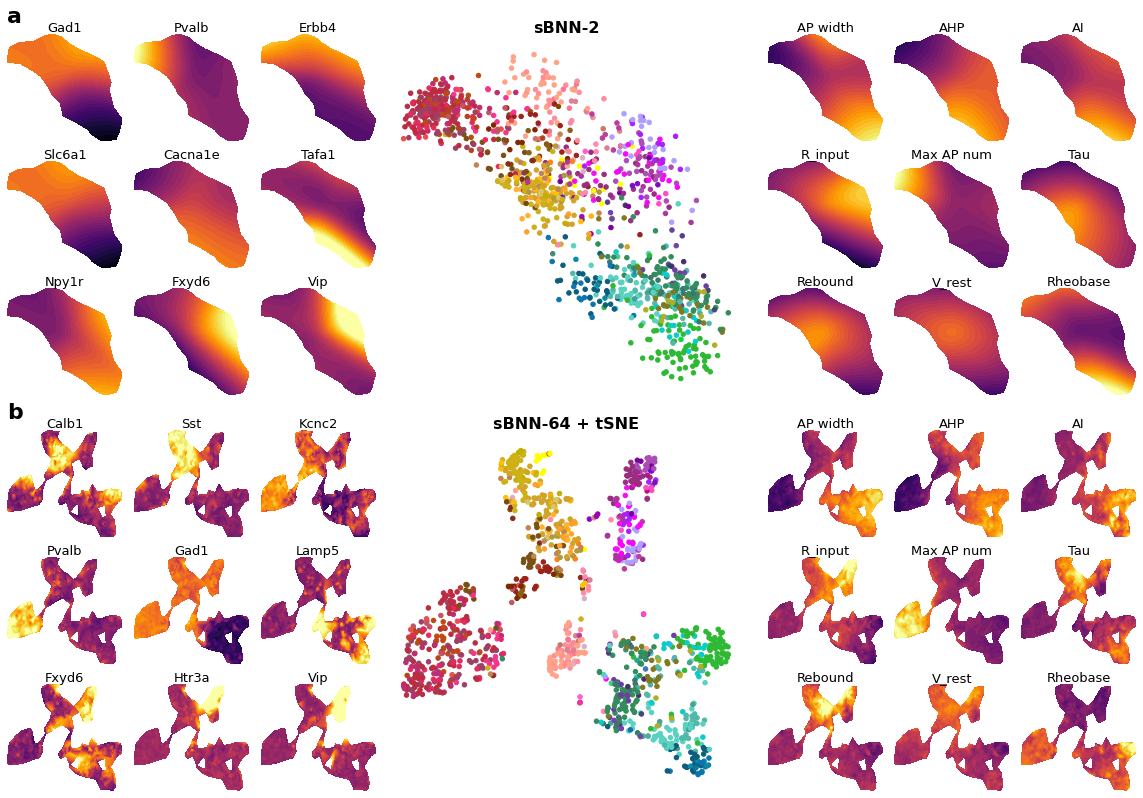

In [176]:
fig=plt.figure(figsize=(16,11))
ax_list = create_axes(fig)

ephys_feature_indices_for_visualization=[4,5,6,8,9,10,11,12,13]
genes_indices_for_visualization_64d=[-1,-2,10,-4,-5,-6,-7,-8,-3]
genes_indices_for_visualization_2d=[-1,-2,-3,-4,5,-6,10,12,14]


########################
# sBNN, 2D bottleneck   

ax_list[0].scatter(nlb_latent[:, 0], nlb_latent[:, 1],
            c = [scala['colors'][ctype] for ctype in scala['map']], s=20)
ax_list[0].set_xticks([])
ax_list[0].set_yticks([])
ax_list[0].set_title('sBNN-2', fontsize=16, fontweight='bold')
for i, ax in enumerate(ax_list[1:10]):
    latent_space_genes(nlb_saved_model_AE, nlb_latent, nlb_latent, scala['X'][:, nlb_ind_genes], 
        genes_indices_for_visualization_2d[i], scala['gene_names'][nlb_ind_genes], triangle_max_len=20, axis=ax)
for i, ax in enumerate(ax_list[10:19]):
    latent_space_ephys(nlb_saved_model, nlb_latent, scala['X'][:, nlb_ind_genes], scala['Y'], \
        ephys_feature_indices_for_visualization[i], scala['ephys_features'], triangle_max_len=20, axis=ax)

########################
# sBNN, 64D bottleneck

ax_list[19].scatter(nl_Z[:, 0], nl_Z[:, 1],
            c = [scala['colors'][ctype] for ctype in scala['map']], s=20)
ax_list[19].set_xticks([])
ax_list[19].set_yticks([])
ax_list[19].set_title('sBNN-64 + tSNE', fontsize=16, fontweight='bold')
#nlb_gene_feature_indices_for_visualization=[-1,-2,-3,-4,-5,15,1,8,12]
for i, ax in enumerate(ax_list[20:29]):
    latent_space_genes(nl_saved_model_AE, nl_latent, nl_Z, scala['X'][:, nl_ind_genes], 
        genes_indices_for_visualization_64d[i], scala['gene_names'][nl_ind_genes], triangle_max_len=120, axis=ax)
for i, ax in enumerate(ax_list[29:38]):
    latent_space_ephys(nl_saved_model, nl_Z, scala['X'][:, nl_ind_genes], scala['Y'], \
        ephys_feature_indices_for_visualization[i], scala['ephys_features'], triangle_max_len=120, axis=ax)

    
for ax in ax_list:
    sns.despine(ax=ax,left=True, bottom=True)
    
fig.text(0, .97, 'a', fontsize=22, fontweight='bold')
fig.text(0, .47, 'b', fontsize=22, fontweight='bold')


plt.savefig('figures/scala_everything_nl.png', bbox_inches = 'tight',
     pad_inches = 0)
plt.savefig('figures/scala_everything_nl.pdf', bbox_inches = 'tight',
    pad_inches = 0)

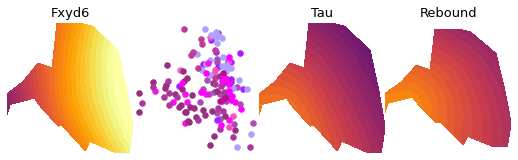

In [184]:
# first zoomed in for Vip for the revision

# Select Vip neurons
Vip_list=['Vip Sncg', 'Vip Serpinf1_1', 'Vip Serpinf1_2', 'Vip Serpinf1_3', 'Vip Htr1f',
 'Vip Gpc3', 'Vip C1ql1', 'Vip Mybpc1_1', 'Vip Mybpc1_2', 'Vip Mybpc1_3', 'Vip Chat_1',
 'Vip Chat_2', 'Vip Igfbp6_1', 'Vip Igfbp6_2']
cell_id_to_cell_type=scala['map']
Vip_cells=cell_id_to_cell_type==Vip_list[0]
for ctype in Vip_list[1:]:
    Vip_cells|=cell_id_to_cell_type==ctype
Vip_cells=np.where(Vip_cells==True)[0]

gene_overlay=scala['gene_names'][nlb_ind_genes][12]

# visualize
fig = plt.figure(figsize=(7, 1.8))
ax_genes_1=plt.axes([0,0,.25,1])
ax_latent=plt.axes([.25,0,.25,1])
ax_ephys_1=plt.axes([.5,0,.25, 1])
ax_ephys_2=plt.axes([.75,0,.25, 1])
for ctype in Vip_list:
    ax_latent.scatter(nlb_latent[np.array(cell_id_to_cell_type)==ctype, 0],
                      nlb_latent[np.array(cell_id_to_cell_type)==ctype, 1], c = scala['colors'][ctype], s=30)
#ax_latent.set_ylim(1, ax_latent.get_ylim()[1])
ax_latent.set_xticks([])
ax_latent.set_yticks([])
latent_space_genes(nlb_saved_model_AE, nlb_latent[Vip_cells,:], nlb_latent[Vip_cells,:],
                   scala['X'][Vip_cells,:][:,nlb_ind_genes], 
        np.where(scala['gene_names'][nlb_ind_genes]==gene_overlay)[0][0], scala['gene_names'][nlb_ind_genes],
                   triangle_max_len=10, axis=ax_genes_1)
latent_space_ephys(nlb_saved_model, nlb_latent[Vip_cells,:], scala['X'][Vip_cells,:][:,nlb_ind_genes],
                   scala['Y'][Vip_cells,:], \
        np.where(scala['ephys_features']=='Tau')[0][0], scala['ephys_features'], triangle_max_len=10, axis=ax_ephys_1)
latent_space_ephys(nlb_saved_model, nlb_latent[Vip_cells,:], scala['X'][Vip_cells,:][:,nlb_ind_genes],
                   scala['Y'][Vip_cells,:], \
        np.where(scala['ephys_features']=='Rebound')[0][0], scala['ephys_features'], triangle_max_len=10, axis=ax_ephys_2)
ax_ephys_2.set_ylim(ax_latent.get_ylim()[0], ax_latent.get_ylim()[1])
ax_genes_1.set_title(gene_overlay, fontsize=13, y=1)
ax_ephys_1.set_title('Tau', fontsize=13, y=1)
ax_ephys_2.set_title('Rebound', fontsize=13, y=1)
sns.despine(left=True, bottom=True)
# for ax in [ax_genes_1, ax_latent, ax_ephys_1, ax_ephys_2]:
#     ax.set_aspect(aspect='equal')
# plt.savefig('figures/preliminary/Vip_zoomed_in.png', bbox_inches = 'tight',
#      pad_inches = 0)
# plt.savefig('figures/preliminary/Vip_zoomed_in.pdf', bbox_inches = 'tight',
#     pad_inches = 0)

In [38]:
# mirror horizontally and vertically if you want
l_Z[:,0]=-l_Z[:,0]
#l_Z[:,1]=-l_Z[:,1]

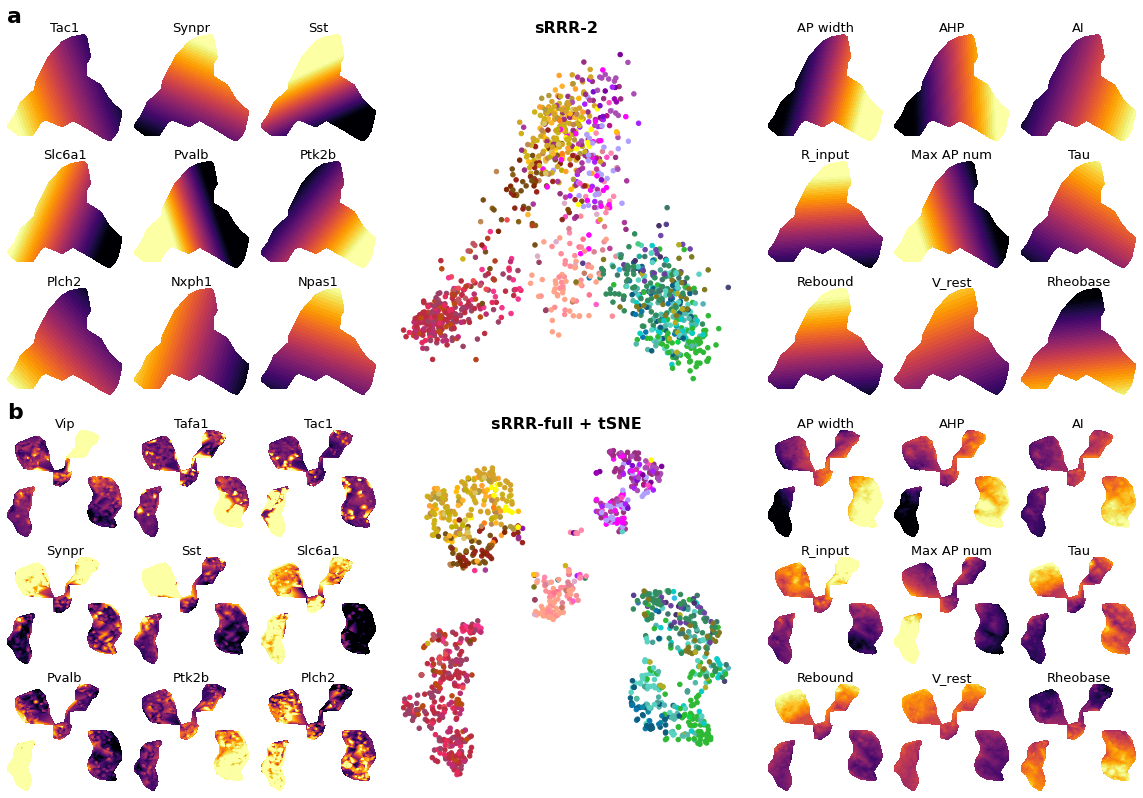

In [177]:
fig=plt.figure(figsize=(16,11))
ax_list = create_axes(fig)

ephys_feature_indices_for_visualization=[4,5,6,8,9,10,11,12,13]



########################
# sRRR, rank=2 

ax_list[0].scatter((scala['X']@vx_rank2)[:, 0], (scala['X']@vx_rank2)[:, 1],
            c = [scala['colors'][ctype] for ctype in scala['map']], s=20)
ax_list[0].set_xticks([])
ax_list[0].set_yticks([])
ax_list[0].set_title('sRRR-2', fontsize=16, fontweight='bold')
for i, ax in enumerate(ax_list[1:10]):
    latent_space_genes_sRRR(scala['X']@vx_rank2, scala['X']@vx_rank2, vx_rank2, 
        -(i+1), scala['gene_names'], triangle_max_len=20, axis=ax)
for i, ax in enumerate(ax_list[10:19]):
    latent_space_ephys_sRRR(scala['X']@vx_rank2, scala['X']@vx_rank2, vy_rank2,\
        ephys_feature_indices_for_visualization[i], scala['ephys_features'], triangle_max_len=20, axis=ax)

########################
# sRRR, full rank 

ax_list[19].scatter(l_Z[:, 0], l_Z[:, 1],
            c = [scala['colors'][ctype] for ctype in scala['map']], s=20)
ax_list[19].set_xticks([])
ax_list[19].set_yticks([])
ax_list[19].set_title('sRRR-full + tSNE', fontsize=16, fontweight='bold')
for i, ax in enumerate(ax_list[20:29]):
    latent_space_genes_sRRR(scala['X']@vx_rank16, l_Z, vx_rank16, 
        -(i+1), scala['gene_names'], triangle_max_len=90, axis=ax)
for i, ax in enumerate(ax_list[29:38]):
    latent_space_ephys_sRRR(scala['X']@vx_rank16, l_Z, vy_rank16,\
        ephys_feature_indices_for_visualization[i], scala['ephys_features'], triangle_max_len=90, axis=ax)

    
for ax in ax_list:
    sns.despine(ax=ax,left=True, bottom=True)
    
fig.text(0, .97, 'a', fontsize=22, fontweight='bold')
fig.text(0, .47, 'b', fontsize=22, fontweight='bold')

plt.savefig('figures/scala_everything_l.png', bbox_inches = 'tight',
     pad_inches = 0)
plt.savefig('figures/scala_everything_l.pdf', bbox_inches = 'tight',
    pad_inches = 0)

#### Gouwens dataset.

In [40]:
weights_after_unfreezing = []
cvfold_id=1111
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format('gouwens_2020_tf2', cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing.append(saved_model.get_weights()[0])
nlb_weights_after_unfreezing_g = np.array(weights_after_unfreezing)

In [41]:
lasso_id=2
cvfold_id=1111
nlb_saved_model_g = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format('gouwens_2020_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
nlb_encoder_g = Model(nlb_saved_model_g.input, nlb_saved_model_g.get_layer('bottleneck').output)
nlb_ind_genes_g = np.argsort(np.linalg.norm(nlb_weights_after_unfreezing_g, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
nlb_latent_g = nlb_encoder_g.predict(gouwens['X'][:, nlb_ind_genes_g])                 # bottleneck representation

nlb_saved_model_AE_g = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_AE_{}_{}_{}.h5'.\
                        format('gouwens_2020_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [42]:
cvfold_id=8888
weights_after_unfreezing = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format('gouwens_2020_tf2', cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing.append(saved_model.get_weights()[0])
nl_weights_after_unfreezing_g = np.array(weights_after_unfreezing)

In [43]:
lasso_id=2
cvfold_id=8888
nl_saved_model_g = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format('gouwens_2020_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
nl_encoder_g = Model(nl_saved_model_g.input, nl_saved_model_g.get_layer('bottleneck').output)
nl_ind_genes_g = np.argsort(np.linalg.norm(nl_weights_after_unfreezing_g, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
nl_latent_g = nl_encoder_g.predict(gouwens['X'][:, nl_ind_genes_g])                 # bottleneck representation

nl_saved_model_AE_g = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_AE_{}_{}_{}.h5'.\
                        format('gouwens_2020_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

In [44]:
nl_Z_g = tsne.fit(nl_latent_g)

--------------------------------------------------------------------------------
TSNE(callbacks=None, callbacks_every_iters=50, dof=1, early_exaggeration=12,
     early_exaggeration_iter=250, exaggeration=None, final_momentum=0.8,
     initial_momentum=0.5, initialization='pca', ints_in_interval=1,
     learning_rate='auto', max_grad_norm=None, max_step_norm=5,
     metric='euclidean', metric_params=None, min_num_intervals=50,
     n_components=2, n_interpolation_points=3, n_iter=500, n_jobs=8,
     negative_gradient_method='auto', neighbors='auto', perplexity=30,
     random_state=42, theta=0.5, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 1.02 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.09 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization

In [58]:
# mirror horizontally if you want
nl_Z_g[:,0]=-nl_Z_g[:,0]

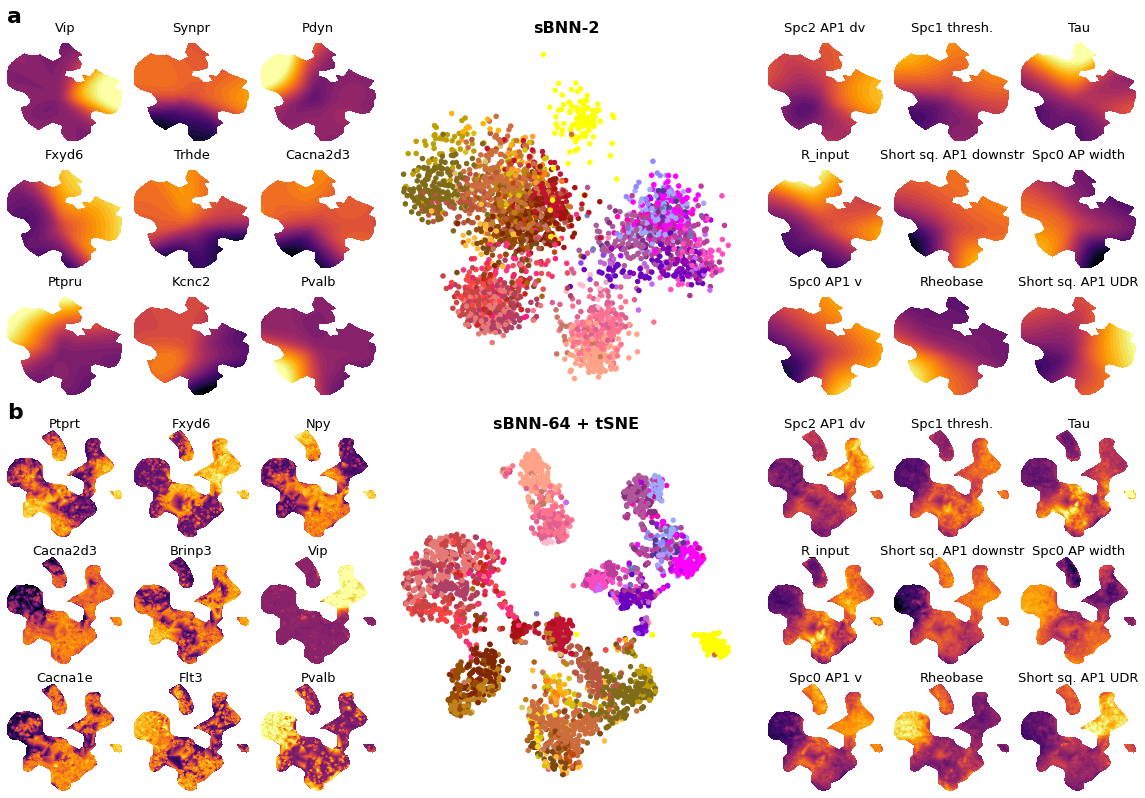

In [178]:
fig=plt.figure(figsize=(16,11))
ax_list = create_axes(fig)

g_ephys_feature_indices_for_visualization=[ 7, 27, 46, 45, 41, 29,  0, 50, 42]

########################
# sBNN, 2D bottleneck   

ax_list[0].scatter(nlb_latent_g[:, 0], nlb_latent_g[:, 1],
            c = [gouwens['colors'][ctype] for ctype in gouwens['map']], s=20)
ax_list[0].set_xticks([])
ax_list[0].set_yticks([])
ax_list[0].set_title('sBNN-2', fontsize=16, fontweight='bold')
for i, ax in enumerate(ax_list[1:10]):
    latent_space_genes(nlb_saved_model_AE_g, nlb_latent_g, nlb_latent_g, gouwens['X'][:, nlb_ind_genes_g], 
        -(i+1), gouwens['gene_names'][nlb_ind_genes_g], triangle_max_len=60, axis=ax)
for i, ax in enumerate(ax_list[10:19]):
    latent_space_ephys(nlb_saved_model_g, nlb_latent_g, gouwens['X'][:, nlb_ind_genes_g], gouwens['Y'], \
        g_ephys_feature_indices_for_visualization[i], gouwens['ephys_features'], triangle_max_len=60, axis=ax)

########################
# sBNN, 64D bottleneck

ax_list[19].scatter(nl_Z_g[:, 0], nl_Z_g[:, 1],
            c = [gouwens['colors'][ctype] for ctype in gouwens['map']], s=20)
ax_list[19].set_xticks([])
ax_list[19].set_yticks([])
ax_list[19].set_title('sBNN-64 + tSNE', fontsize=16, fontweight='bold')
for i, ax in enumerate(ax_list[20:29]):
    latent_space_genes(nl_saved_model_AE_g, nl_latent_g, nl_Z_g, gouwens['X'][:, nl_ind_genes_g], 
        -(i+1), gouwens['gene_names'][nl_ind_genes_g], triangle_max_len=130, axis=ax)

for i, ax in enumerate(ax_list[29:38]):
    latent_space_ephys(nl_saved_model_g, nl_Z_g, gouwens['X'][:, nl_ind_genes_g], gouwens['Y'], \
        g_ephys_feature_indices_for_visualization[i], gouwens['ephys_features'], triangle_max_len=130, axis=ax)

    
# I check the consistency of shorter and original names in the next code block
gouwens_shorter_ephys_names_to_show=['Spc2 AP1 dv', 'Spc1 thresh.', 'Tau', 'R_input', \
                                                          'Short sq. AP1 downstr', 'Spc0 AP width', \
                                                          'Spc0 AP1 v', 'Rheobase', 'Short sq. AP1 UDR']
for i, ax in enumerate(ax_list[29:38]):
    ax.set_title(gouwens_shorter_ephys_names_to_show[i], fontsize=13, y=0.97)

for i, ax in enumerate(ax_list[10:19]):
    ax.set_title(gouwens_shorter_ephys_names_to_show[i], fontsize=13, y=0.97)
    
for ax in ax_list:
    sns.despine(ax=ax,left=True, bottom=True)
    
fig.text(0, .97, 'a', fontsize=22, fontweight='bold')
fig.text(0, .47, 'b', fontsize=22, fontweight='bold')


plt.savefig('figures/gouwens_everything_nl.png', bbox_inches = 'tight',
     pad_inches = 0)
plt.savefig('figures/gouwens_everything_nl.pdf', bbox_inches = 'tight',
    pad_inches = 0)

#### CITE-seq dataset.

In [46]:
weights_after_unfreezing = []
cvfold_id=1111
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format('stoeckius_2017_tf2', cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing.append(saved_model.get_weights()[0])
nlb_weights_after_unfreezing_s = np.array(weights_after_unfreezing)

In [47]:
lasso_id=2
cvfold_id=1111
nlb_saved_model_s = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format('stoeckius_2017_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
nlb_encoder_s = Model(nlb_saved_model_s.input, nlb_saved_model_s.get_layer('bottleneck').output)
nlb_ind_genes_s = np.argsort(np.linalg.norm(nlb_weights_after_unfreezing_s, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
nlb_latent_s = nlb_encoder_s.predict(stoeckius['X'][:, nlb_ind_genes_s])                 # bottleneck representation

nlb_saved_model_AE_s = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_AE_{}_{}_{}.h5'.\
                        format('stoeckius_2017_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [48]:
cvfold_id=6666
weights_after_unfreezing = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format('stoeckius_2017_tf2', cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing.append(saved_model.get_weights()[0])
nl_weights_after_unfreezing_s = np.array(weights_after_unfreezing)

In [49]:
lasso_id=2
cvfold_id=6666
nl_saved_model_s = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format('stoeckius_2017_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
nl_encoder_s = Model(nl_saved_model_s.input, nl_saved_model_s.get_layer('bottleneck').output)
nl_ind_genes_s = np.argsort(np.linalg.norm(nl_weights_after_unfreezing_s, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
nl_latent_s = nl_encoder_s.predict(stoeckius['X'][:, nl_ind_genes_s])                 # bottleneck representation

nl_saved_model_AE_s = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_AE_{}_{}_{}.h5'.\
                        format('stoeckius_2017_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

In [50]:
nl_Z_s = tsne.fit(nl_latent_s)

--------------------------------------------------------------------------------
TSNE(callbacks=None, callbacks_every_iters=50, dof=1, early_exaggeration=12,
     early_exaggeration_iter=250, exaggeration=None, final_momentum=0.8,
     initial_momentum=0.5, initialization='pca', ints_in_interval=1,
     learning_rate='auto', max_grad_norm=None, max_step_norm=5,
     metric='euclidean', metric_params=None, min_num_intervals=50,
     n_components=2, n_interpolation_points=3, n_iter=500, n_jobs=8,
     negative_gradient_method='auto', neighbors='auto', perplexity=30,
     random_state=42, theta=0.5, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 2.15 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.20 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization

In [182]:
nl_Z_s[:,0]=-nl_Z_s[:,0]

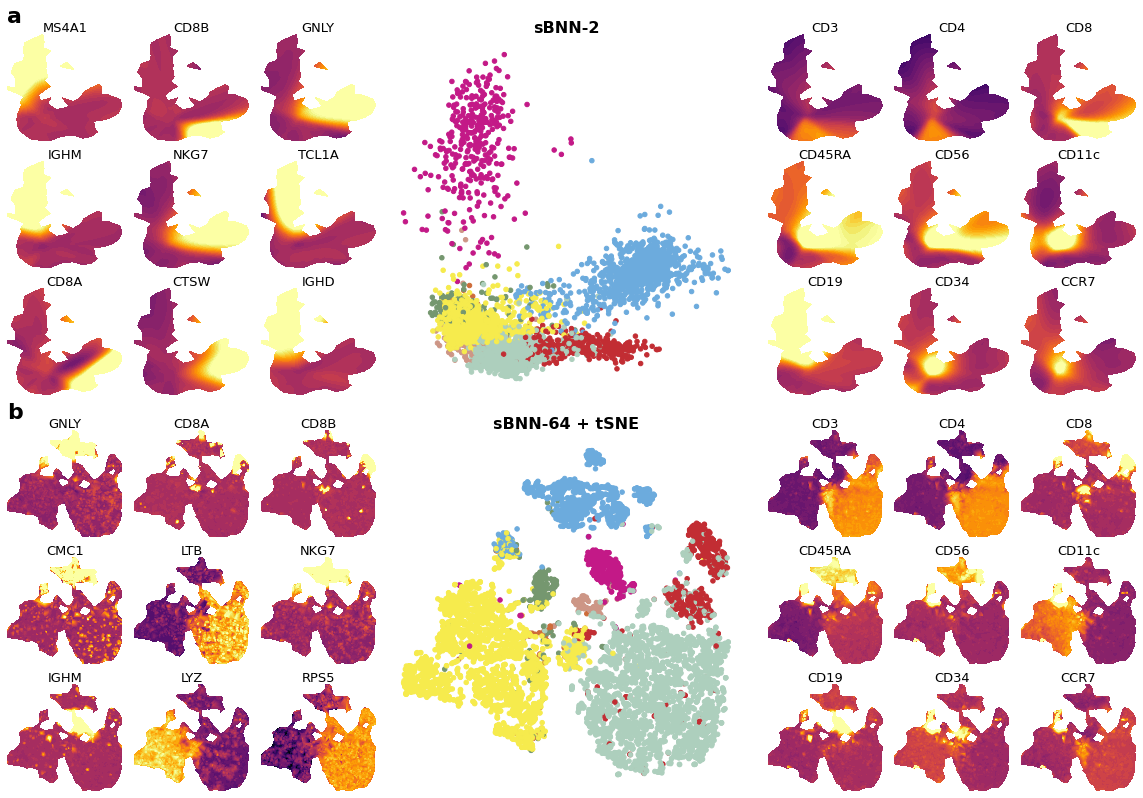

In [183]:
fig=plt.figure(figsize=(16,11))
ax_list = create_axes(fig)

s_feature_indices_for_visualization=[0,1,2,3,4,7,9,10,12]

########################
# sBNN, 2D bottleneck   

ax_list[0].scatter(nlb_latent_s[:, 0], nlb_latent_s[:, 1],
            c = np.array([stoeckius['map'][c] for c in stoeckius['celltypes']]), s=20)
ax_list[0].set_xticks([])
ax_list[0].set_yticks([])
ax_list[0].set_title('sBNN-2', fontsize=16, fontweight='bold')
for i, ax in enumerate(ax_list[1:10]):
    latent_space_genes(nlb_saved_model_AE_s, nlb_latent_s, nlb_latent_s, stoeckius['X'][:, nlb_ind_genes_s], 
        -(i+1), stoeckius['gene_names'][nlb_ind_genes_s], triangle_max_len=60, axis=ax)
for i, ax in enumerate(ax_list[10:19]):
    latent_space_ephys(nlb_saved_model_s, nlb_latent_s, stoeckius['X'][:, nlb_ind_genes_s], stoeckius['Y'], \
        s_feature_indices_for_visualization[i], stoeckius['adt_features'], triangle_max_len=60, axis=ax)
    
########################
# sBNN, 64D bottleneck

ax_list[19].scatter(nl_Z_s[:, 0], nl_Z_s[:, 1],
            c = np.array([stoeckius['map'][c] for c in stoeckius['celltypes']]), s=20)
ax_list[19].set_xticks([])
ax_list[19].set_yticks([])
ax_list[19].set_title('sBNN-64 + tSNE', fontsize=16, fontweight='bold')
for i, ax in enumerate(ax_list[20:29]):
    latent_space_genes(nl_saved_model_AE_s, nl_latent_s, nl_Z_s, stoeckius['X'][:, nl_ind_genes_s], 
        -(i+1), stoeckius['gene_names'][nl_ind_genes_s], triangle_max_len=170, axis=ax)

for i, ax in enumerate(ax_list[29:38]):
    latent_space_ephys(nl_saved_model_s, nl_Z_s, stoeckius['X'][:, nl_ind_genes_s], stoeckius['Y'], \
        s_feature_indices_for_visualization[i], stoeckius['adt_features'], triangle_max_len=170, axis=ax)
    
for ax in ax_list:
    sns.despine(ax=ax,left=True, bottom=True)
    
fig.text(0, .97, 'a', fontsize=22, fontweight='bold')
fig.text(0, .47, 'b', fontsize=22, fontweight='bold')


plt.savefig('figures/stoeckius_everything_nl.png', bbox_inches = 'tight',
     pad_inches = 0)
plt.savefig('figures/stoeckius_everything_nl.pdf', bbox_inches = 'tight',
    pad_inches = 0)

#### M1 dataset, ion channel genes only.

In [52]:
weights_after_unfreezing = []
cvfold_id=1234
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format('scala_2020_with_ion_channel_genes_tf2', cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing.append(saved_model.get_weights()[0])
nlb_weights_after_unfreezing_icg = np.array(weights_after_unfreezing)

In [53]:
lasso_id=2
cvfold_id=1234
nlb_saved_model_icg = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format('scala_2020_with_ion_channel_genes_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
nlb_encoder_icg = Model(nlb_saved_model_icg.input, nlb_saved_model_icg.get_layer('bottleneck').output)
nlb_ind_genes_icg = np.argsort(np.linalg.norm(nlb_weights_after_unfreezing_icg, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
nlb_latent_icg = nlb_encoder_icg.predict(scala_icg['X'][:, nlb_ind_genes_icg])                 # bottleneck representation

nlb_saved_model_AE_icg = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_AE_{}_{}_{}.h5'.\
                        format('scala_2020_with_ion_channel_genes_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [54]:
cvfold_id=3366
weights_after_unfreezing = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format('scala_2020_with_ion_channel_genes_tf2', cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing.append(saved_model.get_weights()[0])
nl_weights_after_unfreezing_icg = np.array(weights_after_unfreezing)

In [55]:
lasso_id=2
cvfold_id=3366
nl_saved_model_icg = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format('scala_2020_with_ion_channel_genes_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
nl_encoder_icg = Model(nl_saved_model_icg.input, nl_saved_model_icg.get_layer('bottleneck').output)
nl_ind_genes_icg = np.argsort(np.linalg.norm(nl_weights_after_unfreezing_icg, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
nl_latent_icg = nl_encoder_icg.predict(scala_icg['X'][:, nl_ind_genes_icg])                 # bottleneck representation

nl_saved_model_AE_icg = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_AE_{}_{}_{}.h5'.\
                        format('scala_2020_with_ion_channel_genes_tf2', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

In [56]:
nl_Z_icg = tsne.fit(nl_latent_icg)

--------------------------------------------------------------------------------
TSNE(callbacks=None, callbacks_every_iters=50, dof=1, early_exaggeration=12,
     early_exaggeration_iter=250, exaggeration=None, final_momentum=0.8,
     initial_momentum=0.5, initialization='pca', ints_in_interval=1,
     learning_rate='auto', max_grad_norm=None, max_step_norm=5,
     metric='euclidean', metric_params=None, min_num_intervals=50,
     n_components=2, n_interpolation_points=3, n_iter=500, n_jobs=8,
     negative_gradient_method='auto', neighbors='auto', perplexity=30,
     random_state=42, theta=0.5, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.25 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.03 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization

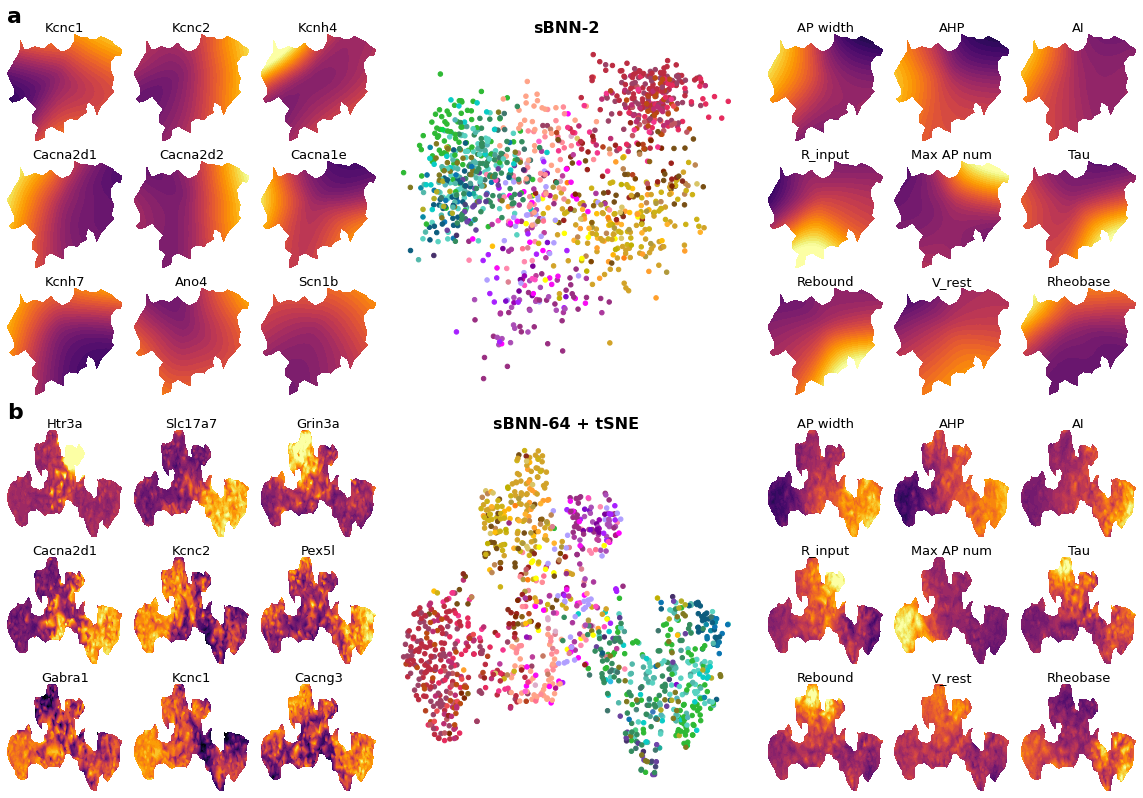

In [181]:
fig=plt.figure(figsize=(16,11))
ax_list = create_axes(fig)


icg_ephys_feature_indices_for_visualization=[4,5,6,8,9,10,11,12,13]
icg_gene_feature_indices_for_visualization=[16,18,14,22,9,13,5,1,2]

########################
# sBNN, 2D bottleneck   

ax_list[0].scatter(nlb_latent_icg[:, 0], nlb_latent_icg[:, 1],
            c = np.array([scala_icg['colors'][c] for c in scala_icg['map']]), s=20)
ax_list[0].set_xticks([])
ax_list[0].set_yticks([])
ax_list[0].set_title('sBNN-2', fontsize=16, fontweight='bold')
for i, ax in enumerate(ax_list[1:10]):
    latent_space_genes(nlb_saved_model_AE_icg, nlb_latent_icg, nlb_latent_icg, scala_icg['X'][:, nlb_ind_genes_icg], 
        icg_gene_feature_indices_for_visualization[i], scala_icg['gene_names'][nlb_ind_genes_icg], triangle_max_len=60, axis=ax)
for i, ax in enumerate(ax_list[10:19]):
    latent_space_ephys(nlb_saved_model_icg, nlb_latent_icg, scala_icg['X'][:, nlb_ind_genes_icg], scala_icg['Y'], \
        icg_ephys_feature_indices_for_visualization[i], scala_icg['ephys_features'], triangle_max_len=60, axis=ax)

########################
# sBNN, 64D bottleneck

ax_list[19].scatter(nl_Z_icg[:, 0], nl_Z_icg[:, 1],
            c = np.array([scala_icg['colors'][c] for c in scala_icg['map']]), s=20)
ax_list[19].set_xticks([])
ax_list[19].set_yticks([])
ax_list[19].set_title('sBNN-64 + tSNE', fontsize=16, fontweight='bold')
for i, ax in enumerate(ax_list[20:29]):
    latent_space_genes(nl_saved_model_AE_icg, nl_latent_icg, nl_Z_icg, scala_icg['X'][:, nl_ind_genes_icg], 
        -(i+1), scala_icg['gene_names'][nl_ind_genes_icg], triangle_max_len=130, axis=ax)

for i, ax in enumerate(ax_list[29:38]):
    latent_space_ephys(nl_saved_model_icg, nl_Z_icg, scala_icg['X'][:, nl_ind_genes_icg], scala_icg['Y'], \
        icg_ephys_feature_indices_for_visualization[i], scala_icg['ephys_features'], triangle_max_len=130, axis=ax)

    
for ax in ax_list:
    sns.despine(ax=ax,left=True, bottom=True)
    
fig.text(0, .97, 'a', fontsize=22, fontweight='bold')
fig.text(0, .47, 'b', fontsize=22, fontweight='bold')


plt.savefig('figures/scala_everything_ion_channel_genes_nl.png', bbox_inches = 'tight',
     pad_inches = 0)
plt.savefig('figures/scala_everything_ion_channel_genes_nl.pdf', bbox_inches = 'tight',
    pad_inches = 0)

In [119]:
# def create_axes_2(fig): # to add a zoomed in version of a specific type
#     # return axes to construct a less big figure
    
#     if fig is None:
#         fig = plt.figure(figsize=(9, 6))
#     else: fig = fig
    
#     width = 0.1 # width of every small heatmap plot
#     height = 0.08 # height of every small heatmap plot
#     shift = 0.2 # shift for every heatmap vertially
    
#     ax_latent=plt.axes([.33,0.5+shift,0.31,0.28])
#     ax_genes_1=plt.axes([0,0.7+shift,width,height])
#     ax_genes_2=plt.axes([0.11,0.7+shift,width,height])
#     ax_genes_3=plt.axes([0.22,0.7+shift,width,height])
    
#     ax_genes_4=plt.axes([0,0.6+shift,width,height])
#     ax_genes_5=plt.axes([0.11,0.6+shift,width,height])
#     ax_genes_6=plt.axes([0.22,0.6+shift,width,height])
    
#     ax_genes_7=plt.axes([0,0.5+shift,width,height])
#     ax_genes_8=plt.axes([0.11,0.5+shift,width,height])
#     ax_genes_9=plt.axes([0.22,0.5+shift,width,height])
    
#     ax_ephys_1=plt.axes([0.66,0.7+shift, width,height])
#     ax_ephys_2=plt.axes([0.77,0.7+shift, width,height])
#     ax_ephys_3=plt.axes([0.88,0.7+shift, width,height])
    
#     ax_ephys_4=plt.axes([0.66,0.6+shift, width,height])
#     ax_ephys_5=plt.axes([0.77,0.6+shift, width,height])
#     ax_ephys_6=plt.axes([0.88,0.6+shift, width,height])
    
#     ax_ephys_7=plt.axes([0.66,0.5+shift, width,height])
#     ax_ephys_8=plt.axes([0.77,0.5+shift, width,height])
#     ax_ephys_9=plt.axes([0.88,0.5+shift, width,height])
    
#     b_ax_latent=plt.axes([.33,0.15+shift,0.31,0.28])    
#     b_ax_genes_1=plt.axes([0,0.35+shift,width,height])
#     b_ax_genes_2=plt.axes([0.11,0.35+shift,width,height])
#     b_ax_genes_3=plt.axes([0.22,0.35+shift,width,height])
    
#     b_ax_genes_4=plt.axes([0,0.25+shift,width,height])
#     b_ax_genes_5=plt.axes([0.11,0.25+shift,width,height])
#     b_ax_genes_6=plt.axes([0.22,0.25+shift,width,height])
    
#     b_ax_genes_7=plt.axes([0,0.15+shift,width,height])
#     b_ax_genes_8=plt.axes([0.11,0.15+shift,width,height])
#     b_ax_genes_9=plt.axes([0.22,0.15+shift,width,height])
    
#     b_ax_ephys_1=plt.axes([0.66,0.35+shift, width,height])
#     b_ax_ephys_2=plt.axes([0.77,0.35+shift, width,height])
#     b_ax_ephys_3=plt.axes([0.88,0.35+shift, width,height])
    
#     b_ax_ephys_4=plt.axes([0.66,0.25+shift, width,height])
#     b_ax_ephys_5=plt.axes([0.77,0.25+shift, width,height])
#     b_ax_ephys_6=plt.axes([0.88,0.25+shift, width,height])
    
#     b_ax_ephys_7=plt.axes([0.66, 0.15+shift, width,height])
#     b_ax_ephys_8=plt.axes([0.77, 0.15+shift, width,height])
#     b_ax_ephys_9=plt.axes([0.88, 0.15+shift, width,height])
    
#     zoomed_in_ax_genes_1=plt.axes([0,0.05,0.25,0.22])
#     zoomed_in_ax_latent=plt.axes([.25,0.05,.25,0.22])
#     zoomed_in_ax_ephys_1=plt.axes([.5,0.05,.25,0.22])
#     zoomed_in_ax_ephys_2=plt.axes([.75,0.05,.25,0.22])
    
    
#     return [ax_latent, ax_genes_1, ax_genes_2, ax_genes_3, ax_genes_4, ax_genes_5, ax_genes_6, \
#             ax_genes_7, ax_genes_8, ax_genes_9, ax_ephys_1, ax_ephys_2, ax_ephys_3, ax_ephys_4, \
#             ax_ephys_5, ax_ephys_6, ax_ephys_7, ax_ephys_8, ax_ephys_9, \
#             b_ax_latent, b_ax_genes_1, b_ax_genes_2, b_ax_genes_3, b_ax_genes_4, b_ax_genes_5, b_ax_genes_6, \
#             b_ax_genes_7, b_ax_genes_8, b_ax_genes_9, b_ax_ephys_1, b_ax_ephys_2, b_ax_ephys_3, b_ax_ephys_4, \
#             b_ax_ephys_5, b_ax_ephys_6, b_ax_ephys_7, b_ax_ephys_8, b_ax_ephys_9, zoomed_in_ax_genes_1, \
#             zoomed_in_ax_latent, zoomed_in_ax_ephys_1, zoomed_in_ax_ephys_2
#            ]

In [118]:
# # Together
# fig=plt.figure(figsize=(19,17))
# ax_list=create_axes_2(fig)

# ephys_feature_indices_for_visualization=[4,5,6,8,9,10,11,12,13]
# genes_indices_for_visualization_64d=[-1,-2,10,-4,-5,-6,-7,-8,-9]
# genes_indices_for_visualization_2d=[-1,-2,-3,-4,5,-6,10,-8,-9]

# ########################
# # sBNN, 64D bottleneck

# ax_list[0].scatter(nl_Z[:, 0], nl_Z[:, 1],
#             c = [scala['colors'][ctype] for ctype in scala['map']], s=20)
# ax_list[0].set_xticks([])
# ax_list[0].set_yticks([])
# ax_list[0].set_title('sBNN-64 + tSNE', fontsize=16, fontweight='bold')
# #nlb_gene_feature_indices_for_visualization=[-1,-2,-3,-4,-5,15,1,8,12]
# for i, ax in enumerate(ax_list[1:10]):
#     latent_space_genes(nl_saved_model_AE, nl_latent, nl_Z, scala['X'][:, nl_ind_genes], 
#         genes_indices_for_visualization_64d[i], scala['gene_names'][nl_ind_genes], triangle_max_len=120,
#                        fontsize=15, axis=ax)
# for i, ax in enumerate(ax_list[10:19]):
#     latent_space_ephys(nl_saved_model, nl_Z, scala['X'][:, nl_ind_genes], scala['Y'], \
#         ephys_feature_indices_for_visualization[i], scala['ephys_features'], triangle_max_len=120,
#                        fontsize=15, axis=ax)

# ########################
# # sBNN, 2D bottleneck   

# ax_list[19].scatter(nlb_latent[:, 0], nlb_latent[:, 1],
#             c = [scala['colors'][ctype] for ctype in scala['map']], s=20)
# ax_list[19].set_xticks([])
# ax_list[19].set_yticks([])
# ax_list[19].set_title('sBNN-2', fontsize=16, fontweight='bold')
# for i, ax in enumerate(ax_list[20:29]):
#     latent_space_genes(nlb_saved_model_AE, nlb_latent, nlb_latent, scala['X'][:, nlb_ind_genes], 
#         genes_indices_for_visualization_2d[i], scala['gene_names'][nlb_ind_genes], triangle_max_len=20,
#                        fontsize=15, axis=ax)
# for i, ax in enumerate(ax_list[29:38]):
#     latent_space_ephys(nlb_saved_model, nlb_latent, scala['X'][:, nlb_ind_genes], scala['Y'], \
#         ephys_feature_indices_for_visualization[i], scala['ephys_features'], triangle_max_len=20,
#                        fontsize=15, axis=ax)


    
# for ctype in Vip_list:
#     ax_list[39].scatter(nlb_latent[np.array(cell_id_to_cell_type)==ctype, 0],
#                       nlb_latent[np.array(cell_id_to_cell_type)==ctype, 1], c = scala['colors'][ctype], s=20)
# #ax_latent.set_ylim(1, ax_latent.get_ylim()[1])
# ax_list[39].set_xticks([])
# ax_list[39].set_yticks([])
# latent_space_genes(nlb_saved_model_AE, nlb_latent[Vip_cells,:], nlb_latent[Vip_cells,:],
#                    scala['X'][Vip_cells,:][:,nlb_ind_genes], 
#         np.where(scala['gene_names'][nlb_ind_genes]=='Vip')[0][0], scala['gene_names'][nlb_ind_genes],
#                    triangle_max_len=10, axis=ax_list[38])
# latent_space_ephys(nlb_saved_model, nlb_latent[Vip_cells,:], scala['X'][Vip_cells,:][:,nlb_ind_genes],
#                    scala['Y'][Vip_cells,:], \
#         np.where(scala['ephys_features']=='Tau')[0][0], scala['ephys_features'], triangle_max_len=10, axis=ax_list[40])
# latent_space_ephys(nlb_saved_model, nlb_latent[Vip_cells,:], scala['X'][Vip_cells,:][:,nlb_ind_genes],
#                    scala['Y'][Vip_cells,:], \
#         np.where(scala['ephys_features']=='Rebound')[0][0], scala['ephys_features'], triangle_max_len=10, axis=ax_list[41])
# #ax_ephys_2.set_ylim(ax_latent.get_ylim()[0], ax_latent.get_ylim()[1])
# ax_list[38].set_title('Vip', fontsize=15, y=1)
# ax_list[40].set_title('Tau', fontsize=15, y=1)
# ax_list[41].set_title('Rebound', fontsize=15, y=1)


# for ax in ax_list:
#     sns.despine(ax=ax,left=True, bottom=True)
    
# fig.text(0, 1, 'a', fontsize=22, fontweight='bold')
# fig.text(0, .68, 'b', fontsize=22, fontweight='bold')
# fig.text(0, .28, 'c', fontsize=22, fontweight='bold')

# plt.savefig('figures/scala_everything_nl_w_Vip_zoomed_in.png', bbox_inches = 'tight',
#      pad_inches = 0)
# plt.savefig('figures/scala_everything_nl_w_Vip_zoomed_in.pdf', bbox_inches = 'tight',
#     pad_inches = 0)